In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import qnmfits

In [2]:
sim = qnmfits.SXS(ID=305, zero_time=(2,2))

# Interpolate onto a regular grid of times, and remove the constant offset at 
# the end
times = np.linspace(0,100,500)[:-1]
h22 = interp1d(sim.times, sim.h[2,2]-sim.h[2,2][-1])(times)

/Users/eliot/Documents/Research/Ringdown/qnmfits/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


Lets assume that, if the seven overtone model is physical, then a fit from the time of peak strain gives amplitudes that are basically correct:

In [40]:
t0 = 0
modes = [(2,2,n,1) for n in range(7+1)]

best_fit = qnmfits.ringdown_fit(
    times, h22, modes, Mf=sim.Mf, chif=sim.chif_mag, t0=t0
    )

clean_h22 = best_fit['model']

ref_amps = abs(best_fit['C'])
print(ref_amps)

[ 0.96794858  4.17777085 11.19098776 22.47994623 32.07458947 28.53289589
 13.84826029  2.8344038 ]


And we can also get their expected decay:

In [62]:
t0_array = np.linspace(0,50,250)

frequencies = qnmfits.qnm.omega_list(modes, sim.chif_mag, sim.Mf)
damping_times = -1/np.imag(frequencies)

expected_amps = ref_amps*np.exp(-np.outer(t0_array, (1/damping_times)))

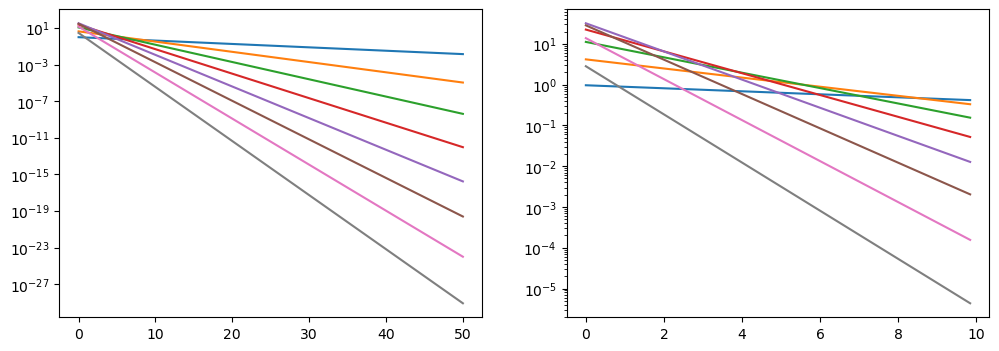

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].set_yscale('log')
axs[1].set_yscale('log')

for amp in expected_amps.T:
    axs[0].plot(t0_array, amp)
    axs[1].plot(t0_array[:50], amp[:50])

In [64]:
def plot_amplitude_deviation(wf_data):

    amp_list = []

    for t0 in t0_array:
        
        best_fit = qnmfits.ringdown_fit(
            times,
            wf_data,
            modes=modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
            )
        
        amp_list.append(best_fit['C'])
        
    amp_array = np.array(amp_list)

    fig, axs = plt.subplots(1, 2, figsize=(12,4), dpi=180)
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    # ax.set_ylim(1e-3, 50)

    for n in range(len(modes)):

        axs[0].plot(t0_array, abs((abs(amp_array[:,n])-expected_amps[:,n])), label=f'$n={n}$')
        axs[1].plot(t0_array, abs((abs(amp_array[:,n])-expected_amps[:,n])/expected_amps[:,n]))

    axs[0].set_xlabel('$t_0$')
    axs[1].set_xlabel('$t_0$')

    axs[0].set_ylabel('$|\delta C|$')
    axs[1].set_ylabel('$|\delta C/C|$')

    _ = axs[0].legend()

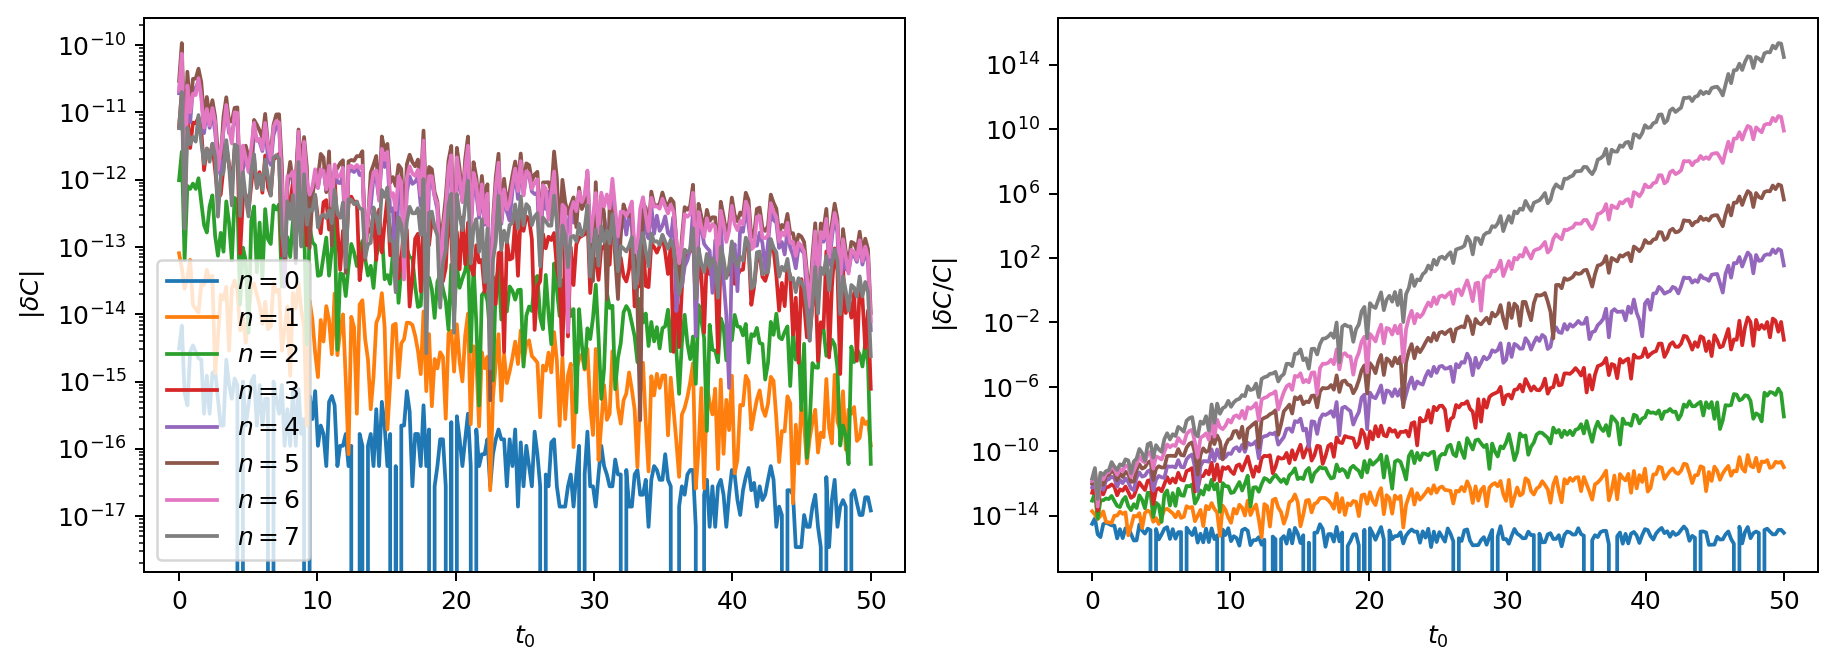

In [66]:
plot_amplitude_deviation(clean_h22)

In [ ]:
def plot_amplitude_over_time(t0_array, wf_times, wf_data, modes):

    frequencies = qnmfits.qnm.omega_list(modes, sim.chif_mag, sim.Mf)

    amp_list = []

    for t0 in t0_array:
        
        best_fit = qnmfits.ringdown_fit(
            wf_times,
            wf_data,
            modes=modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
            )
        
        amp_list.append(best_fit['C'])
        
    amp_array = np.array(amp_list)

    fig, ax = plt.subplots(dpi=180)
    ax.set_yscale('log')
    # ax.set_ylim(1e-3, 50)

    for n in range(len(modes)):

        ax.plot(t0_array, abs(amp_array[:,n]), label=f'$n={n}$')

        # The expected amplitude decay from the QNM frequency
        tau = -1/np.imag(frequencies[n])
        expected_amp = abs(amp_array[:,n][0])*np.exp(-t0_array/tau)

        ax.plot(t0_array, expected_amp, c=f'C{n}', ls='--')

    ax.set_xlabel('$t_0$')
    ax.set_ylabel('$|C|$')

    _ = ax.legend()

Perform a seven-overtone fit at a range of ringdown start times. It is well known that the amplitudes don't decay in the expected way:

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)]

plot_amplitude_over_time(t0_array, times, h22, modes)

And if we generate some perfect data which only contains QNMs, then there is no problem (up to numerical error):

In [ ]:
best_fit = qnmfits.ringdown_fit(
    times,
    h22,
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

clean_h22 = best_fit['model']

t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)]

plot_amplitude_over_time(t0_array, times, clean_h22, modes)

What is the difference? We know the SXS data has some error, and also some subdominant modes like the (3,2,0,1)... all of this should be contained in the difference between our clean waveform and the actual simulation data

In [ ]:
fig, ax = plt.subplots(dpi=180)

residual = h22 - clean_h22

ax.plot(times, np.real(residual))
ax.plot(times, np.imag(residual))

We can try to improve the situation by including the (3,2,0,1) mode in our fit:

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)] + [(3,2,0,1)]

plot_amplitude_over_time(t0_array, times, h22, modes)

This helps the $n=1$ overtone a bit, but otherwise we're still not doing well. Now the residual looks like this:

In [ ]:
modes = [(2,2,n,1) for n in range(7+1)] + [(3,2,0,1)]

best_fit = qnmfits.ringdown_fit(
    times,
    h22,
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

clean_h22_with_320 = best_fit['model']

residual = h22 - clean_h22_with_320

fig, ax = plt.subplots(dpi=180)

ax.plot(times, np.real(residual))
ax.plot(times, np.imag(residual))

And still the clean waveform works fine:

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)] + [(3,2,0,1)]

plot_amplitude_over_time(t0_array, times, clean_h22_with_320, modes)

The above residual is somehow messing up the overtone amplitudes. Lets mimic the residual with a damped sinusoid, add it to the clean waveform, and see if we can reproduce the behaviour we're getting with the SXS data.

In [ ]:
def fake_residual(times, A, f, tau):
    return A*np.exp(2*np.pi*1j*f*times)*np.exp(-times/tau)

In [ ]:
fig, ax = plt.subplots(dpi=180)

ax.plot(times, np.real(residual), alpha=0.5)
ax.plot(times, np.imag(residual), alpha=0.5)

ax.plot(times, np.real(fake_residual(times, 1e-4, 0.1, 10)))
ax.plot(times, np.imag(fake_residual(times, 1e-4, 0.1, 10)))

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)] + [(3,2,0,1)]

plot_amplitude_over_time(t0_array, times, clean_h22_with_320+fake_residual(times, 1e-4, 0.1, 10), modes)

This stops the decay of the overtones behaving as expected. All we have done is added a damped sinusoid to the data which we haven't modelled. We could do the same by simply not modelling the higher overtones in the data:

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(4+1)] + [(3,2,0,1)]

plot_amplitude_over_time(t0_array, times, clean_h22_with_320, modes)

But this behaves as expected - the initial decay isn't as expected, but at later times when the unmodelled overtones decay we get the expected decay. So maybe the problem is long-lived unmodelled modes? We can mimick that by removing the (3,2,0,1) mode in our model:

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)]

plot_amplitude_over_time(t0_array, times, clean_h22_with_320, modes)

This looks promising. What if we vary the frequency/damping time of the unmodelled mode?

In [ ]:
np.real(qnmfits.qnm.omega(2, 2, 0, 1, sim.chif_mag, sim.Mf))/(2*np.pi)

In [ ]:
np.real(qnmfits.qnm.omega(2, 2, 7, 1, sim.chif_mag, sim.Mf))/(2*np.pi)

In [ ]:
-1/np.imag(qnmfits.qnm.omega(2, 2, 0, 1, sim.chif_mag, sim.Mf))

In [ ]:
-1/np.imag(qnmfits.qnm.omega(2, 2, 7, 1, sim.chif_mag, sim.Mf))

In [ ]:
# Roughly the (2,2,0) and (2,2,7) frequencies and damping times
f_minmax = [0.07, 0.09]
tau_minmax = [0.7, 12]

res = 50

t0_array = np.linspace(0,10,2)
modes = [(2,2,n,1) for n in range(7+1)] + [(3,2,0,1)]
frequencies = qnmfits.qnm.omega_list(modes, sim.chif_mag, sim.Mf)

# Create the f and tau arrays
f_array = np.linspace(f_minmax[0], f_minmax[1], res)
tau_array = np.linspace(tau_minmax[0], tau_minmax[1], res)

# List to store the deviation in the n=7 amplitude from the expected value
n7_deviation = []

for i in range(len(f_array)*len(tau_array)):

    f = f_array[int(i/len(f_array))]
    tau = tau_array[i%len(tau_array)]

    # Create a fake residual
    fake_res = fake_residual(times, 1e-4, f, tau)

    data_with_res = clean_h22_with_320 + fake_res

    amp_list = []

    for t0 in t0_array:
        
        best_fit = qnmfits.ringdown_fit(
            times,
            data_with_res,
            modes=modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
            )
        
        amp_list.append(best_fit['C'])
        
    amp_array = np.array(amp_list)

    fig, ax = plt.subplots(dpi=180)
    ax.set_yscale('log')
    # ax.set_ylim(1e-3, 50)

    for n in range(len(modes)):

        ax.plot(t0_array, abs(amp_array[:,n]), label=f'$n={n}$')

        # The expected amplitude decay from the QNM frequency
        tau = -1/np.imag(frequencies[n])
        expected_amp = abs(amp_array[:,n][0])*np.exp(-t0_array/tau)

    mm_list.append(best_fit['mismatch'])

# Convert the list of mismatches to a grid
mm_grid = np.reshape(np.array(mm_list), (len(re_array), len(im_array))).T

return mm_grid

In [ ]:
def plot_amplitude_over_time(t0_array, wf_times, wf_data, modes):

    frequencies = qnmfits.qnm.omega_list(modes, sim.chif_mag, sim.Mf)

    amp_list = []

    for t0 in t0_array:
        
        best_fit = qnmfits.ringdown_fit(
            wf_times,
            wf_data,
            modes=modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
            )
        
        amp_list.append(best_fit['C'])
        
    amp_array = np.array(amp_list)

    fig, ax = plt.subplots(dpi=180)
    ax.set_yscale('log')
    # ax.set_ylim(1e-3, 50)

    for n in range(len(modes)):

        ax.plot(t0_array, abs(amp_array[:,n]), label=f'$n={n}$')

        # The expected amplitude decay from the QNM frequency
        tau = -1/np.imag(frequencies[n])
        expected_amp = abs(amp_array[:,n][0])*np.exp(-t0_array/tau)

        ax.plot(t0_array, expected_amp, c=f'C{n}', ls='--')

    ax.set_xlabel('$t_0$')
    ax.set_ylabel('$|C|$')

    _ = ax.legend()

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)]

plot_amplitude_over_time(t0_array, times, clean_h22+fake_residual(times, 1e-5, 0.08845543842435726, 11.740900063388384), modes)

I wouldn't call any of this "overfitting" - if anything the problem is underfitting because the model doesn't contain everything in the data. I can try and overfit by using a model with the (3,2,0,1) mode in data which doesn't have it, and it doesn't cause any problems:

In [ ]:
t0_array = np.linspace(0,50,250)
modes = [(2,2,n,1) for n in range(7+1)] + [(3,2,0,1)]

plot_amplitude_over_time(t0_array, times, clean_h22, modes)